In [1]:
import pandas as pd
import re
from collections import Counter
import time
import os
from joblib import dump, load
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np


In [2]:
class AppendPrediction(TransformerMixin, BaseEstimator):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def transform(self, X):
        # Predict using the provided model
        predictions = self.model.predict(X)
        df = np.column_stack((X, predictions/512))

        # Append predictions as a new column
        return df

    
class AppendUnderestimationClassifiler(TransformerMixin, BaseEstimator):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y=None):
        self.model.fit(X, (X[:,-1] < (y*0.9)/512))
        return self

    def transform(self, X):
        # Predict using the provided model
        predictions = self.model.predict(X)
        df = np.column_stack((X, predictions.astype(int)))

        # Append predictions as a new column
        return df
    
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, func):
        self.func = func

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.func(X)
    
def analyze_text(x):
    # Use Counter for efficient character counting
    counter = Counter(x)
    # Direct calculations from Counter
    spaces_count = counter[' ']
    esc_char_count = counter['\\']
    quotation_count = sum(counter[char] for char in '\'"`“”')
    alpha_count = sum(count for char, count in counter.items() if char.isalpha())
    digit_count = sum(count for char, count in counter.items() if char.isdigit())
    dash_underscore_count = sum(counter[char] for char in '-_—')
    unique_char_count = len(counter)
    # Calculated fields
    char_count = len(x)
    word_len_estim = alpha_count / (spaces_count + 1)

    return char_count, spaces_count, quotation_count, dash_underscore_count, alpha_count, digit_count, unique_char_count, esc_char_count, word_len_estim


def preprocess_token_estimator(df):
    # Apply the analyze_text function using map, resulting in a Series of tuples
    analysis_results = df['text'].map(lambda x: analyze_text(x))
    # Naming the result columns
    columns = ['char_count', 'spaces_count', 'quotation_count', 'dash_underscore_count', 'alpha_count', 'digit_count', 'unique_char_count', 'esc_char_count', 'word_len_estim']
    # Convert the Series of tuples into a DataFrame
    df_result = pd.DataFrame(analysis_results.tolist(), index=df.index,
                             columns = columns)
    return df_result
    

preprocess_pipeline = load('datasets/preprocess/preprocess_pipeline.joblib')
X_test = load('datasets/preprocess/X_test.joblib')
X_train = load('datasets/preprocess/X_train.joblib')
X_validation = load('datasets/preprocess/X_validation.joblib')
y_test = load('datasets/preprocess/y_test.joblib')
y_train = load('datasets/preprocess/y_train.joblib')
y_validation = load('datasets/preprocess/y_validation.joblib')

pd.DataFrame(preprocess_pipeline.transform(X_validation)).describe().T

,count,mean,std,min,25%,50%,75%,max
0,200000.0,0.130851,0.142295,0.000000,0.021445,0.079007,0.195636,0.979308
1,200000.0,0.126067,0.139743,0.000000,0.017115,0.075795,0.190709,0.919315
2,200000.0,0.003478,0.013824,0.000000,0.000000,0.000000,0.000000,0.513274
3,200000.0,0.007474,0.015104,0.000000,0.000000,0.000000,0.009615,0.884615
4,200000.0,0.126150,0.137748,0.000000,0.021400,0.074900,0.187695,0.970575
5,200000.0,0.016877,0.032660,0.000000,0.000000,0.000000,0.020290,0.675362
6,200000.0,0.414661,0.164357,0.000000,0.289855,0.420290,0.536232,0.985507
7,200000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,200000.0,0.148825,0.037321,0.000000,0.131579,0.144283,0.158802,0.815789
9,200000.0,0.130073,0.139837,-0.005048,0.021636,0.080765,0.195487,0.916665


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [7]:
X_train_processed = preprocess_pipeline.transform(X_train)
X_validation_processed = preprocess_pipeline.transform(X_validation)
X_test_processed = preprocess_pipeline.transform(X_test)

In [36]:
X_train_processed.shape

(800000, 11)

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping


model_seq_nn = Sequential()
model_seq_nn.add(Input(shape=(X_train_processed.shape[1],)))  # Input layer
model_seq_nn.add(Dense(121, activation='relu'))  # Hidden layer 1
model_seq_nn.add(Dense(11, activation='relu'))  
model_seq_nn.add(Dense(1, activation='linear'))  # Output layer

model_seq_nn.compile(loss='mean_squared_error', optimizer='adam')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.1, restore_best_weights=True)

# Assuming X_train, y_train, X_validation, and y_validation are defined
model_seq_nn.fit(X_train_processed, y_train, epochs=50, batch_size=128, validation_data=(X_validation_processed, y_validation), callbacks=[early_stopping])

# Evaluate the model
mse = MeanSquaredError()
mse.update_state(y_validation, model_seq_nn.predict(X_validation_processed))
print("Validation MSE: ", mse.result().numpy())

Epoch 1/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 605us/step - loss: 1333.9196 - val_loss: 23.4518
Epoch 2/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 574us/step - loss: 18.5121 - val_loss: 19.3647
Epoch 3/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 575us/step - loss: 15.4039 - val_loss: 18.5238
Epoch 4/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 569us/step - loss: 14.9633 - val_loss: 18.6594
Epoch 5/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 566us/step - loss: 14.7631 - val_loss: 18.9370
Epoch 6/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 557us/step - loss: 14.7696 - val_loss: 18.3470
Epoch 7/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 573us/step - loss: 14.7231 - val_loss: 18.3668
Epoch 8/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 567us/step - loss: 14.7485 - val_loss: 18.2794
Epoch 9/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 585us/step - loss: 14.7104 - val_loss: 18.2354
Epoch 10/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 584us/step - loss: 14.7604 - val_loss: 18.3455
Epoch 11/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 567us/step - loss: 14.6324 - va

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 343us/step
Prediction time for 1000 samples:  0.015043065547943116


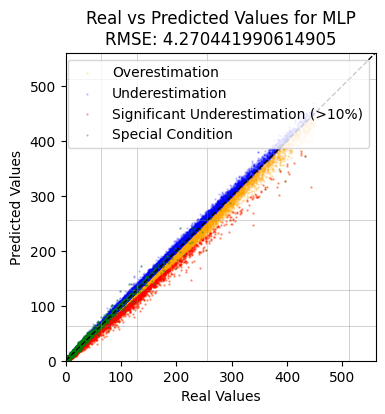

In [104]:
import matplotlib.pyplot as plt

# Predict the validation set
start = time.time()
preds = model_seq_nn.predict(X_validation_processed)
print("Prediction time for 1000 samples: ", 1000*(time.time()-start)/len(y_validation))
preds = preds.reshape(-1)
rmse = np.sqrt(np.mean((y_validation - preds)**2))

# Define the conditions for overestimation and underestimation
overestimated = y_validation >= preds
underestimated = y_validation < preds
significantly_underestimated = y_validation*0.9 > preds
special_condition = X_validation_processed[:,-1] == 1


# Plot setup
plt.figure(figsize=(4, 4))

# Scatter plots for different categories
plt.scatter(y_validation[overestimated], preds[overestimated], color='orange', alpha=0.2, s=0.5, label='Overestimation')
plt.scatter(y_validation[underestimated], preds[underestimated], color='blue', alpha=0.2, s=0.5, label='Underestimation')
plt.scatter(y_validation[significantly_underestimated], preds[significantly_underestimated], color='red', alpha=0.3, s=0.5, label='Significant Underestimation (>10%)')
plt.scatter(y_validation[special_condition], preds[special_condition], color='green', alpha=0.3, s=0.5, label='Special Condition')

# Diagonal line for reference
plt.plot([0, 600], [0, 600], 'k--', lw=1)

# Other reference lines
for i in [64, 128, 256, 512]:
    plt.plot([i, i], [0, 600], 'grey', linestyle='-', lw=0.5, alpha=0.5)
    plt.plot([0, 600], [i, i], 'grey', linestyle='-', lw=0.5, alpha=0.5)

# Labels, title, and limits
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title(f'Real vs Predicted Values for MLP\nRMSE: {rmse}')
plt.xlim([0, 560])
plt.ylim([0, 560])

# Legend
plt.legend()

# Show plot
plt.show()

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam


def asymmetric_mean_squared_error():
    def loss(y_true, y_pred):
        # Ensure tensor variables for vectorized operations
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)

        # Calculate errors
        errors = y_pred - y_true

        # Identify underestimations more than 10%
        underestimations = errors < -0.1 * y_true
        underestim_percentage = K.mean(K.cast(underestimations, 'float32'))
        underestim_adj = (1 + underestim_percentage)**5

        # Calculate squared errors with double penalty for underestimations
        squared_errors = K.switch(errors < 0, (errors**2) * 2, errors**2)

        asymmetric_sqr_err = K.sum(squared_errors) / K.cast(K.shape(y_pred)[0], 'float32')
        # Adjusted sum of squared errors
        asymmetric_sqr_err_adj = asymmetric_sqr_err * underestim_adj

        return asymmetric_sqr_err_adj
    return loss


model = Sequential()
model.add(Input(shape=(X_train_processed.shape[1],)))  # Input layer
model.add(Dense(121, activation='relu'))  # Hidden layer 1
model.add(Dense(11, activation='relu'))  
model.add(Dense(1, activation='linear'))  # Output layer

optimizer = Adam(learning_rate=0.01)

model.compile(loss=asymmetric_mean_squared_error(), optimizer=optimizer)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.1, restore_best_weights=True)

# Assuming X_train, y_train, X_validation, and y_validation are defined
model.fit(X_train_processed, y_train, epochs=50, batch_size=128, validation_data=(X_validation_processed, y_validation), callbacks=[early_stopping])

# Evaluate the model
mse = MeanSquaredError()
mse.update_state(y_validation, model.predict(X_validation_processed))
print("Validation MSE: ", mse.result().numpy())

Epoch 1/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 603us/step - loss: 78763.8906 - val_loss: 61.4034
Epoch 2/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 583us/step - loss: 40.4447 - val_loss: 34.9046
Epoch 3/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 584us/step - loss: 30.9997 - val_loss: 35.7556
Epoch 4/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 599us/step - loss: 29.4436 - val_loss: 46.1940
Epoch 5/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 584us/step - loss: 29.0633 - val_loss: 39.5913
Epoch 6/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 581us/step - loss: 28.4800 - val_loss: 39.7185
Epoch 7/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 579us/step - loss: 28.7470 - val_loss: 45.9834
Epoch 8/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 577us/step - loss: 28.5217 - val_loss: 43.1810
Epoch 9/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 584us/step - loss: 28.5114 - val_loss: 43.2504
Epoch 10/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 581us/step - loss: 28.7313 - val_loss: 33.6899
Epoch 11/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 584us/step - loss: 28.2386 - v

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 344us/step
Prediction time for 1000 samples:  0.015060954093933106


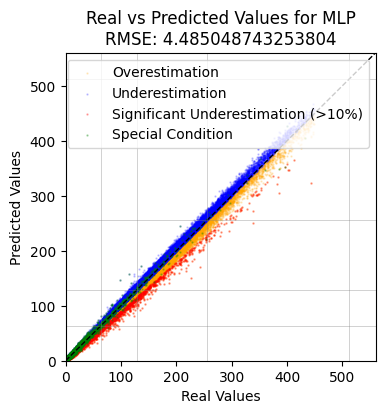

In [55]:
import matplotlib.pyplot as plt

# Predict the validation set
start = time.time()
preds = model.predict(X_validation_processed)
print("Prediction time for 1000 samples: ", 1000*(time.time()-start)/len(y_validation))
preds = preds.reshape(-1)
rmse = np.sqrt(np.mean((y_validation - preds)**2))

# Define the conditions for overestimation and underestimation
overestimated = y_validation >= preds
underestimated = y_validation < preds
significantly_underestimated = y_validation*0.9 > preds
special_condition = X_validation_processed[:,-1] == 1


# Plot setup
plt.figure(figsize=(4, 4))

# Scatter plots for different categories
plt.scatter(y_validation[overestimated], preds[overestimated], color='orange', alpha=0.2, s=0.5, label='Overestimation')
plt.scatter(y_validation[underestimated], preds[underestimated], color='blue', alpha=0.2, s=0.5, label='Underestimation')
plt.scatter(y_validation[significantly_underestimated], preds[significantly_underestimated], color='red', alpha=0.3, s=0.5, label='Significant Underestimation (>10%)')
plt.scatter(y_validation[special_condition], preds[special_condition], color='green', alpha=0.3, s=0.5, label='Special Condition')

# Diagonal line for reference
plt.plot([0, 600], [0, 600], 'k--', lw=1)

# Other reference lines
for i in [64, 128, 256, 512]:
    plt.plot([i, i], [0, 600], 'grey', linestyle='-', lw=0.5, alpha=0.5)
    plt.plot([0, 600], [i, i], 'grey', linestyle='-', lw=0.5, alpha=0.5)

# Labels, title, and limits
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title(f'Real vs Predicted Values for MLP\nRMSE: {rmse}')
plt.xlim([0, 560])
plt.ylim([0, 560])

# Legend
plt.legend()

# Show plot
plt.show()

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train_processed, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_validation_processed)

# Calculate the Mean Squared Error of the predictions
mse = mean_squared_error(y_validation, y_pred)

print("Validation MSE: ", mse)

Validation MSE:  19.81855077139439


Prediction time for 1000 samples:  2.2324323654174806e-05


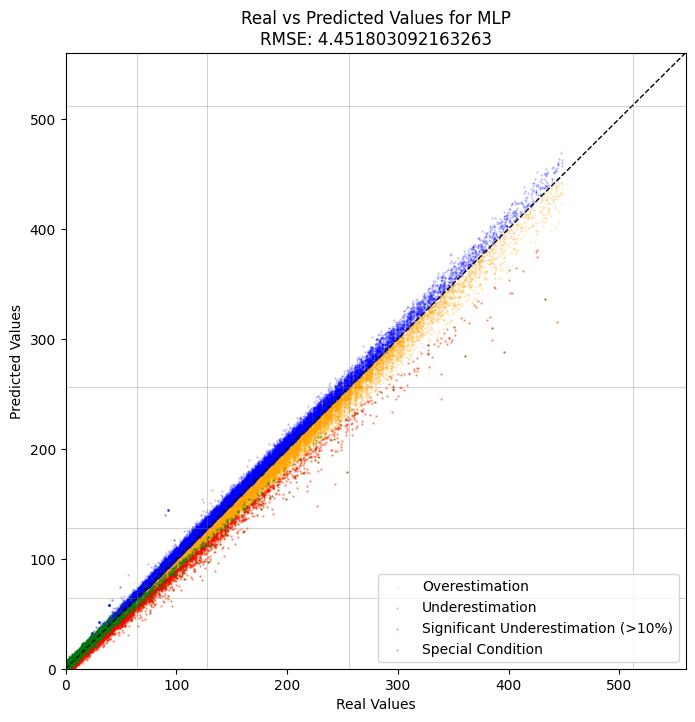

In [53]:
# Predict the validation set
start = time.time()
preds = model.predict(X_validation_processed)
print("Prediction time for 1000 samples: ", 1000*(time.time()-start)/len(y_validation))
preds = preds.reshape(-1)
rmse = np.sqrt(np.mean((y_validation - preds)**2))

# Define the conditions for overestimation and underestimation
overestimated = y_validation >= preds
underestimated = y_validation < preds
significantly_underestimated = y_validation*0.9 > preds
special_condition = X_validation_processed[:,-1] == 1


# Plot setup
plt.figure(figsize=(8, 8))

# Scatter plots for different categories
plt.scatter(y_validation[overestimated], preds[overestimated], color='orange', alpha=0.2, s=0.5, label='Overestimation')
plt.scatter(y_validation[underestimated], preds[underestimated], color='blue', alpha=0.2, s=0.5, label='Underestimation')
plt.scatter(y_validation[significantly_underestimated], preds[significantly_underestimated], color='red', alpha=0.3, s=0.5, label='Significant Underestimation (>10%)')
plt.scatter(y_validation[special_condition], preds[special_condition], color='green', alpha=0.3, s=0.5, label='Special Condition')

# Diagonal line for reference
plt.plot([0, 600], [0, 600], 'k--', lw=1)

# Other reference lines
for i in [64, 128, 256, 512]:
    plt.plot([i, i], [0, 600], 'grey', linestyle='-', lw=0.5, alpha=0.5)
    plt.plot([0, 600], [i, i], 'grey', linestyle='-', lw=0.5, alpha=0.5)

# Labels, title, and limits
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title(f'Real vs Predicted Values for MLP\nRMSE: {rmse}')
plt.xlim([0, 560])
plt.ylim([0, 560])

# Legend
plt.legend()

# Show plot
plt.show()

# Classification

Prediction time for 1000 samples:  0.00041633963584899905
Validation Accuracy:  0.969585

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       358
           1       0.99      0.99      0.99     88505
           2       0.95      0.95      0.95     34871
           3       0.96      0.96      0.96     42011
           4       0.96      0.95      0.96     29165
           5       0.96      0.93      0.94      5090

    accuracy                           0.97    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.97      0.97      0.97    200000



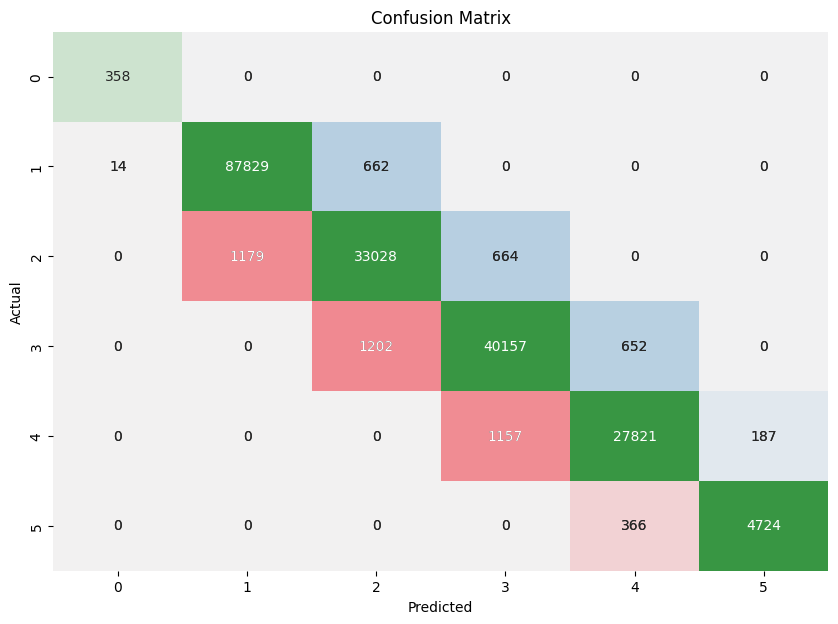

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.colors import Normalize




# Define the bins for the classes
bins = [0, 32, 64, 128, 256, np.inf]
labels = [1, 2, 3, 4, 5]

# Convert the target to ordinal classes
y_train_binned = np.digitize(y_train, bins, right=True)
y_validation_binned = np.digitize(y_validation, bins, right=True)

# Create a Random Forest Classifier model
classifiler = RandomForestClassifier(
                                n_estimators=10,
                                max_depth=100,
                                n_jobs=-1)

# Train the model
classifiler.fit(X_train_processed, y_train_binned)

# Make predictions on the validation set
start = time.time()
y_pred = classifiler.predict(X_validation_processed)
print("Prediction time for 1000 samples: ", 1000*(time.time()-start)/len(y_validation))

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_validation_binned, y_pred)

print("Validation Accuracy: ", accuracy)



# Generate the classification report
class_report = classification_report(y_validation_binned, y_pred)

print("\nClassification Report:")
print(class_report)

# Generate the confusion matrix
conf_mat = confusion_matrix(y_validation_binned, y_pred)

# Create a mask for the upper triangle
mask1 = np.triu(np.ones_like(conf_mat, dtype=bool))
mask2 = np.tril(np.ones_like(conf_mat, dtype=bool))

# Create a custom colormap
matrix_sum = np.sum(conf_mat)

cmap1 = sns.diverging_palette(250, 10, s=80, l=55, as_cmap=True,)
cmap2 = sns.diverging_palette(20, 240, s=80, l=55, as_cmap=True, )
cmap3 = sns.diverging_palette(120, 130, s=80, l=55, as_cmap=True,)
norm = Normalize(vmin=0, vmax=matrix_sum/100)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=cmap3, norm=norm, center=0, cbar=False)
sns.heatmap(conf_mat, annot=True, fmt='d', mask=mask1, norm=norm, cmap=cmap1, center=0, cbar=False)
sns.heatmap(conf_mat, annot=True, fmt='d', mask=mask2, norm=norm, cmap=cmap2, center=0, cbar=False)



# Labels, title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show plot
plt.show()

25000/25000 ━━━━━━━━━━━━━━━━━━━━ 9s 348us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 347us/step
Prediction time for 1000 samples:  0.002834213972091675
Validation Accuracy:  0.97152

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       358
           1       0.99      0.99      0.99     88505
           2       0.95      0.95      0.95     34871
           3       0.96      0.96      0.96     42011
           4       0.97      0.96      0.96     29165
           5       0.96      0.94      0.95      5090

    accuracy                           0.97    200000
   macro avg       0.96      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000



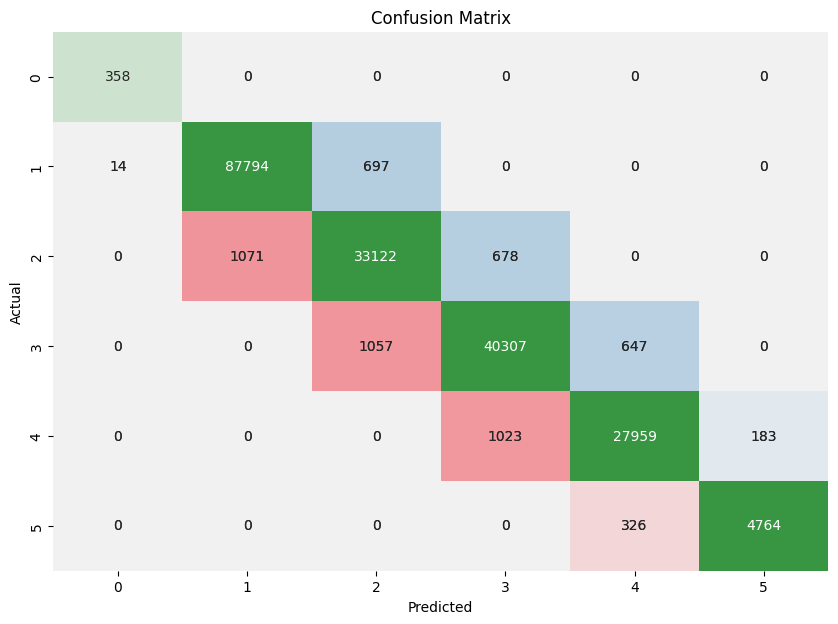

In [110]:
# Generate predictions from the Sequential Neural Network
nn_train_predictions = model_seq_nn.predict(X_train_processed)
nn_validation_predictions = model_seq_nn.predict(X_validation_processed)

# Add the predictions as a new feature to the datasets
X_train_processed_with_nn = np.concatenate([X_train_processed, nn_train_predictions], axis=1)
X_validation_processed_with_nn = np.concatenate([X_validation_processed, nn_validation_predictions], axis=1)

# Create a Random Forest Classifier model
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Train the model with the new datasets
classifier.fit(X_train_processed_with_nn, y_train_binned)

# Make predictions on the validation set
start = time.time()
y_pred = classifier.predict(X_validation_processed_with_nn)
print("Prediction time for 1000 samples: ", 1000*(time.time()-start)/len(y_validation))

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_validation_binned, y_pred)

print("Validation Accuracy: ", accuracy)



# Generate the classification report
class_report = classification_report(y_validation_binned, y_pred)

print("\nClassification Report:")
print(class_report)

# Generate the confusion matrix
conf_mat = confusion_matrix(y_validation_binned, y_pred)

# Create a mask for the upper triangle
mask1 = np.triu(np.ones_like(conf_mat, dtype=bool))
mask2 = np.tril(np.ones_like(conf_mat, dtype=bool))

# Create a custom colormap
matrix_sum = np.sum(conf_mat)

cmap1 = sns.diverging_palette(250, 10, s=80, l=55, as_cmap=True,)
cmap2 = sns.diverging_palette(20, 240, s=80, l=55, as_cmap=True, )
cmap3 = sns.diverging_palette(120, 130, s=80, l=55, as_cmap=True,)
norm = Normalize(vmin=0, vmax=matrix_sum/100)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=cmap3, norm=norm, center=0, cbar=False)
sns.heatmap(conf_mat, annot=True, fmt='d', mask=mask1, norm=norm, cmap=cmap1, center=0, cbar=False)
sns.heatmap(conf_mat, annot=True, fmt='d', mask=mask2, norm=norm, cmap=cmap2, center=0, cbar=False)



# Labels, title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show plot
plt.show()

Epoch 1/50


/Users/emanueleferrari/VSCode/SEC_Cleaner/CleanerSEC/lib/python3.9/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9253 - loss: 0.2000 - val_accuracy: 0.9591 - val_loss: 0.0978
Epoch 2/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9612 - loss: 0.0896 - val_accuracy: 0.9614 - val_loss: 0.0917
Epoch 3/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9625 - loss: 0.0860 - val_accuracy: 0.9582 - val_loss: 0.1018
Epoch 4/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9629 - loss: 0.0848 - val_accuracy: 0.9610 - val_loss: 0.0915
Epoch 5/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9632 - loss: 0.0836 - val_accuracy: 0.9621 - val_loss: 0.0897
Epoch 6/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9635 - loss: 0.0833 - val_accuracy: 0.9611 - val_loss: 0.0921
Epoch 7/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9637 - loss: 0.0823 - val_accuracy: 0.9619 - val_loss: 0.0904
Epoch 8/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9638 - loss: 0.0823 - val_accurac

/Users/emanueleferrari/VSCode/SEC_Cleaner/CleanerSEC/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emanueleferrari/VSCode/SEC_Cleaner/CleanerSEC/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emanueleferrari/VSCode/SEC_Cleaner/CleanerSEC/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       358
           1       0.97      0.99      0.98     88505
           2       0.94      0.91      0.93     34871
           3       0.94      0.95      0.95     42011
           4       0.97      0.93      0.95     29165
           5       0.92      0.95      0.94      5090

    accuracy                           0.96    200000
   macro avg       0.79      0.79      0.79    200000
weighted avg       0.96      0.96      0.96    200000



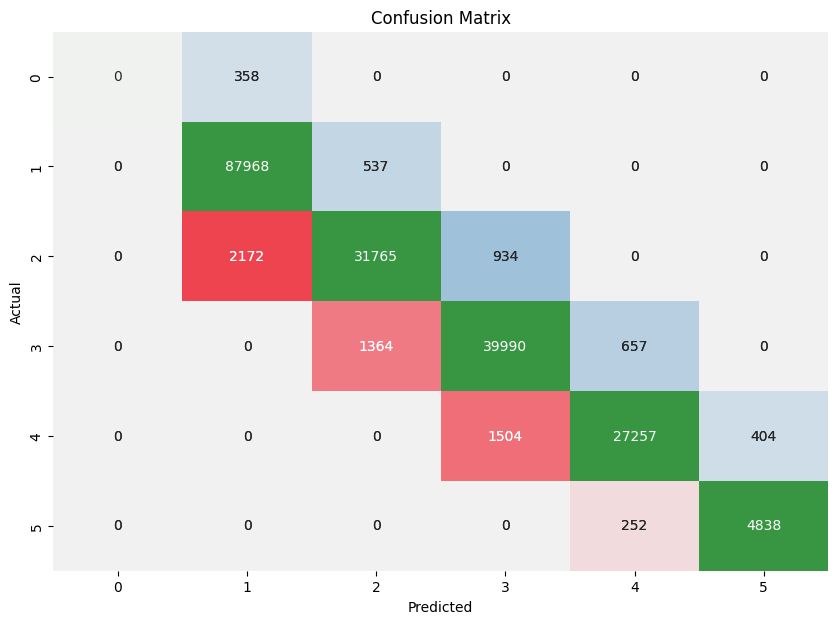

In [145]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Convert the target to one-hot encoding
y_train_encoded = to_categorical(y_train_binned)
y_validation_encoded = to_categorical(y_validation_binned)

# Create a Sequential model
model = Sequential()

# Add layers to the model
model.add(Dense(242, input_dim=X_train_processed.shape[1], activation='relu'))
model.add(Dense(121, activation='relu'))
model.add(Dense(11, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))  # The number of nodes in the output layer should match the number of classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)

# Train the model with validation data and the EarlyStopping callback
model.fit(X_train_processed, y_train_encoded, epochs=100, batch_size=128, validation_data=(X_validation_processed, y_validation_encoded), callbacks=[early_stopping])

# Make predictions on the validation set
start = time.time()
y_pred_probabilities = model.predict(X_validation_processed)
print("Prediction time for 1000 samples: ", 1000*(time.time()-start)/len(y_validation))

y_pred = np.argmax(y_pred_probabilities, axis=-1)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_validation_binned, y_pred)

print("Validation Accuracy: ", accuracy)



# Generate the classification report
class_report = classification_report(y_validation_binned, y_pred)

print("\nClassification Report:")
print(class_report)

# Generate the confusion matrix
conf_mat = confusion_matrix(y_validation_binned, y_pred)

# Create a mask for the upper triangle
mask1 = np.triu(np.ones_like(conf_mat, dtype=bool))
mask2 = np.tril(np.ones_like(conf_mat, dtype=bool))

# Create a custom colormap
matrix_sum = np.sum(conf_mat)

cmap1 = sns.diverging_palette(250, 10, s=80, l=55, as_cmap=True,)
cmap2 = sns.diverging_palette(20, 240, s=80, l=55, as_cmap=True, )
cmap3 = sns.diverging_palette(120, 130, s=80, l=55, as_cmap=True,)
norm = Normalize(vmin=0, vmax=matrix_sum/100)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=cmap3, norm=norm, center=0, cbar=False)
sns.heatmap(conf_mat, annot=True, fmt='d', mask=mask1, norm=norm, cmap=cmap1, center=0, cbar=False)
sns.heatmap(conf_mat, annot=True, fmt='d', mask=mask2, norm=norm, cmap=cmap2, center=0, cbar=False)



# Labels, title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show plot
plt.show()